In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread

columnwidth = 246/72.27
plt.style.use('../custom.mplstyle')
from customcolors import colors, colors10, custom_cmap

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
from scipy.stats import sem
from FKMC.plotting import spread
from FKMC.general import scaling_dimension
import multiprocessing as mp

def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def fit_errors(X, Y, dY):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def fit_no_errors(X, Y):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def scaling_dimension(Ns, IPR, dIPR, use_true_errors = True):
    Y = np.log(IPR).T
    dY = dIPR.T / IPR.T 
    #set a minimum 5% error
    dY = np.maximum(dY, 5/100)
    X = np.broadcast_to(np.log(Ns), Y.shape)
    
    if use_true_errors:
        args = [X, Y, dY]
        fit = fit_errors
    else:
        args = [X, Y]
        fit = fit_no_errors

    m, c, dm, dc = fit(args)

    return m, c, dm, dc

from FKMC.general import scaling_dimension

def interpolate_and_smooth(o):
    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)

    o.dIPR = sem(o.IPR, axis = 1)
    o.IPR = np.mean(o.IPR, axis = 1)
    o.dDOS = sem(o.DOS, axis = 1)
    o.DOS = np.mean(o.DOS, axis = 1)

    o.IPR = smooth(o.IPR, scale = 0.5, axis = -1)
    o.dIPR = smooth(o.dIPR, scale = 0.5, axis = -1)
    o.DOS = smooth(o.DOS, scale = 0.5, axis = -1)

    try:
        o.m, o.c, o.dm, o.dc = scaling_dimension(o.Ns, o.IPR, o.dIPR, use_true_errors = True)
    except:
        print('Scaling dimension fit failed on at least one value, falling back to loop')
        o.m, o.c, o.dm, o.dc = scaling_dimension_multidim(o.Ns, o.IPR, o.dIPR, use_true_errors = True)
    
    return o

In [7]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR

rng = np.random.default_rng()

p = Munch(
        parameters = Munch(beta = np.nan, U = 2, mu=0.0, t = 1, alpha = 1.25, J = 1.0),
        scale = 0.5,
        defect_densities = np.concatenate([np.linspace(0,0.2,10), np.linspace(0.2,1,10)]),
        E_bins = np.linspace(-4, 4, 2000 + 1),
        N_states = int(1e3), # average over N_states // N replications
        Ns = np.array([40, 60,  70,  80, 100, 120, 150, 180, 220, 270]),
        )

#p.Ns = np.array([10,30,50])
#p.N_states = int(1e3)


def calculate_DOS_and_IPR_scaling(defect_density):
    N_Es = len(p.E_bins) - 1
    o = Munch()
    o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(p.Ns), N_Es))
    
    for N_i, N in enumerate(p.Ns):
        M = p.N_states #the number of repetitions to use.
        CDW = (np.arange(N)%2)[None, :]
        disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
        defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
        states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density
            
        params = p.parameters.copy()
        params.N = N
        params.J_matrix = interaction_matrix(**params)
        
        Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)
        
        #calculate the IPR measure
        raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

        DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, p.E_bins, bootstrap_bins = 1)

        interpolate_IPR(p.E_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

        #smooth out the spikey IPR values
        o.DOS[N_i] = smooth(DOS, scale = p.scale, axis = -1)
        o.IPR[N_i] = smooth(IPR, scale = p.scale, axis = -1)

        o.dDOS[N_i] = smooth(dDOS, scale = p.scale, axis = -1)
        o.dIPR[N_i] = smooth(dIPR, scale = p.scale, axis = -1)
    
    
    o.m, c, dm, dc = scaling_dimension(p.Ns, o.IPR, o.dIPR, use_true_errors = True)
    print(f"finished d = {defect_density}\n")
    return o

with mp.Pool(8) as pool:
    data = pool.map(calculate_DOS_and_IPR_scaling, p.defect_densities)

o = Munch()
for name in ["DOS", "IPR", "m"]:
    o[name] = np.array([d[name] for d in data])
    
o.DOS = o.DOS.swapaxes(0,1)    
o.IPR = o.IPR.swapaxes(0,1)

o.update(p)
o.Y = p.defect_densities
o.name = "Uncorrelated\n Disorder"

for name in ["DOS", "IPR", "m"]:
    print(f'shape of o.{name} is {o[name].shape}')
        
#DOS, IPR, IPR_scaling = data.swapaxes(0,1)

finished d = 0.0

finished d = 0.022222222222222223

finished d = 0.044444444444444446

finished d = 0.06666666666666667

finished d = 0.08888888888888889

finished d = 0.13333333333333333

finished d = 0.11111111111111112

finished d = 0.15555555555555556

finished d = 0.17777777777777778

finished d = 0.2

finished d = 0.2888888888888889

finished d = 0.2

finished d = 0.37777777777777777

finished d = 0.4666666666666667

finished d = 0.5555555555555556

finished d = 0.6444444444444445

finished d = 0.8222222222222222

finished d = 0.7333333333333334

finished d = 0.9111111111111112

finished d = 1.0

shape of o.DOS is (10, 20, 2000)
shape of o.IPR is (10, 20, 2000)
shape of o.m is (20, 2000)


In [8]:
p = Path(f'~/HPC_data/pickled_data/disorder_data_temp_sweep_U={o.parameters.U}.pickle').expanduser()
print(f"saving to {p}")
with open(p, 'wb') as f:
    pickle.dump(o, f, pickle.HIGHEST_PROTOCOL)
    print(f'Pickling {p.stem} successful') 

saving to /Users/tom/HPC_data/pickled_data/disorder_data_temp_sweep_U=2.pickle
Pickling disorder_data_temp_sweep_U=2 successful


In [5]:
p = Path('~/HPC_data/pickled_data/disorder_data_temp_sweep_U=2.pickle').expanduser()
with open(p, 'rb') as f:
    o = pickle.load(f)
    print(f'UnPickling {p.stem} was successful') 

UnPickling disorder_data_temp_sweep_U=2 was successful


opening gap_opening because o.parameters.U = 2
o.Ns = [ 40  60  70  80 100 120 150 180 220 270]
N1 = 70, N2 = 40
o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


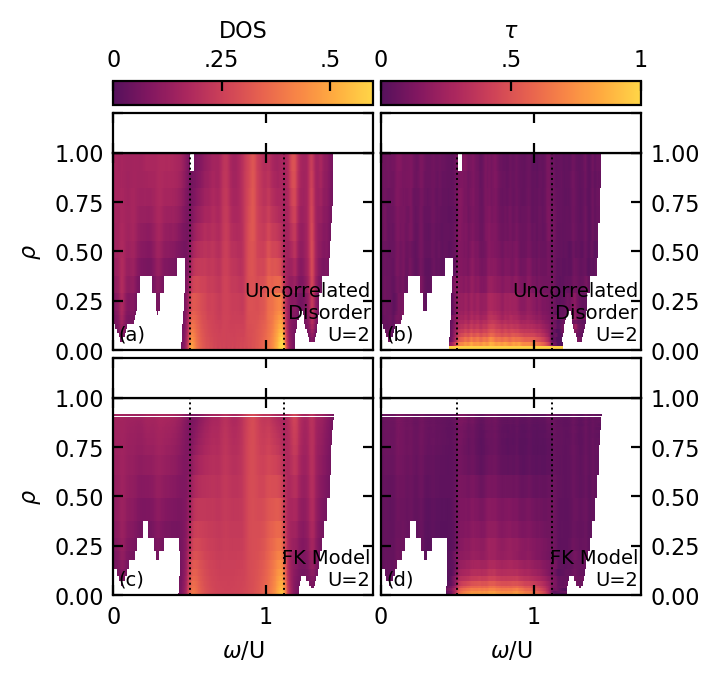

In [6]:
def plot_gap_opening_log_2x2(os, ologs = [None,None], xlim = (-3.5/2, 3.5/2), ylim = (0,1)):
    from FKMC.general import smooth
    import matplotlib.gridspec as gridspec
    shading = 'nearest'
    
    f = plt.figure()
    #the overall grid has rows (cax, ax0, ax1) and two columns
    gs0 = gridspec.GridSpec(nrows = 3, ncols = 2, figure=f, wspace = 0.03,
                                            hspace = 0.05,
                                            height_ratios = (1,10,10),
                                            width_ratios = (1,1))
    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]
    for j,o,olog in zip([1,2], os, ologs):
        #within each ax we split into axes and logaxes part with a subgridspec with hspace = 0
        lgs, rgs = [gs0[j, i].subgridspec(2,1, 
                                          height_ratios = (1,5),
                                          hspace = 0,
                                         ) for i in range(2)]
        axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]
        logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]


        print(f'o.Ns = {o.Ns}')
        i1 = 2; i2 = 0
        N1 = o.Ns[i1]; N2 = o.Ns[i2]
        print(f'N1 = {N1}, N2 = {N2}')


        E_i = 2
        E_threshold = 0.07
        E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
        E = np.where(E > 0.06, E, np.NaN)
        I = np.where(E > 0.06, -o.m, np.NaN)

        if olog:
            olog.E = smooth(olog.DOS[E_i], scale = 0.5, axis = -1)
            olog.E = np.where(olog.E > 0.06, olog.E, np.NaN)
            olog.I = np.where(olog.E > 0.06, -olog.m, np.NaN)
        
        custom_cmap.set_bad(color='white')
        
        #plot the E-T IPR diagram Diagram
        #the norm has to be fully specified (both vmin and vmax) so that the log and normal axes match
        DOSnorm = mpl.colors.Normalize(vmin = 0, vmax = 0.6)
        DOSpcol = axes[0].pcolormesh(o.E_bins[1:]/o.parameters.U, o.Y, E, norm = DOSnorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)
        if olog: logaxes[0].pcolormesh(o.E_bins[1:]/o.parameters.U, olog.Y, olog.E, norm = DOSnorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)

        axes[0].set(ylabel = r'$\rho$', ylim = (0, 0.5), xlim = (-4, 4))

        #plot the E-T IPR diagram Diagram
        Taunorm = mpl.colors.Normalize(vmin = 0, vmax = 1)
        taupcol = axes[1].pcolormesh(o.E_bins[1:]/o.parameters.U, o.Y, I, norm = Taunorm, cmap= custom_cmap, linewidth=0, rasterized = True, shading = shading)
        if olog: logaxes[1].pcolormesh(o.E_bins[1:]/o.parameters.U, olog.T, olog.I, norm = Taunorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)

        
        for a,b in zip(axes, logaxes): 
            #a.tick_params(direction = "in")
            b.tick_params(labelbottom = False)
            a.set(xlim = xlim)
            b.set(xlim = xlim)

            maxliny = ylim[1]

            a.set(ylim = ylim,
                  yticks = [0,1,2,3],
                  xlabel = '$\omega$/U',
                  yscale = 'linear',
            )
            b.set(yscale = 'log')
            b.set(
                ylim = (maxliny,100),
                #yticks = [10,100],
                yticklabels = [],
            )
         
        if j == 1: 
            for ax in axes: ax.tick_params(labelbottom = False)


        axes[1].tick_params(labelleft = False)

        for a in [axes[-1], logaxes[-1]]:
            a.tick_params(labelleft = False, labelright = True)
            
        labels = ["(a)","(b)"] if j == 1 else ["(c)","(d)"]
        for label, ax, color in zip(labels, axes, ['k', 'k']):
            ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
                    fontsize=7, fontweight='normal', color = color)
            ax.text(0.99, 0.03, f'{o.name}\nU={o.parameters.U}', transform=ax.transAxes, va='bottom', ha = 'right',
                    fontsize=7, fontweight='normal', color = color)

        Tc = 2.3
        #pm 1/2 np.sqrt(4*U**2 + 8t**2(1 + cos(ka)))
        bounds = np.array([-1,-1,+1,+1]) * 0.5 * np.sqrt(o.parameters.U**2 + 8*np.array([0,2,0,2])) / o.parameters.U
        #bounds = [-2.3/2, -0.9/2, 0.9/2, 2.3/2]

        for ax in axes[:2]:
            ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
            ax.vlines(x = bounds, ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')
    
    DOScbar = f.colorbar(DOSpcol, cax = caxes[0], orientation="horizontal")
    caxes[0].set(xlabel = 'DOS')  
    caxes[0].xaxis.set_label_position('top') 
    DOScbar.set_ticks([0, .25, .5])
    DOScbar.set_ticklabels(['0', '.25', '.5'])
    caxes[0].tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
    
    taucbar = f.colorbar(taupcol, cax = caxes[1], orientation="horizontal")
    caxes[1].set(xlabel = r'$\tau$')  
    caxes[1].xaxis.set_label_position('top') 
    taucbar.set_ticks([0, .5, 1])
    taucbar.set_ticklabels(['0', '.5', '1'])
    caxes[1].tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
      
    f.subplots_adjust()
    f.set_size_inches(columnwidth,columnwidth)
    return f
    
name = 'gap_opening_U=5'if o.parameters.U == 5 else 'gap_opening'
print(f"opening {name} because o.parameters.U = {o.parameters.U}")
with open(Path(f'~/HPC_data/pickled_data/{name}.pickle').expanduser(), 'rb') as file:
    oFK = pickle.load(file)

oFK.Y = (1 - np.sqrt(oFK.Mf_moments[..., 2].mean(axis = 1)[2]))
oFK.name = "FK Model"

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

if o.parameters.U == 2:
    #oFK.Y[np.isnan(oFK.Y)] = 4.53e-1
    #print(oFK.Y)
    nans, x = nan_helper(oFK.Y)
    oFK.Y[nans]= np.interp(x(nans), x(~nans), oFK.Y[~nans])
    #print(oFK.Y)

f = plot_gap_opening_log_2x2(os = [o,oFK], ologs = [None, None], xlim = (0,1.7), ylim = (0,1))

# with 100 samples
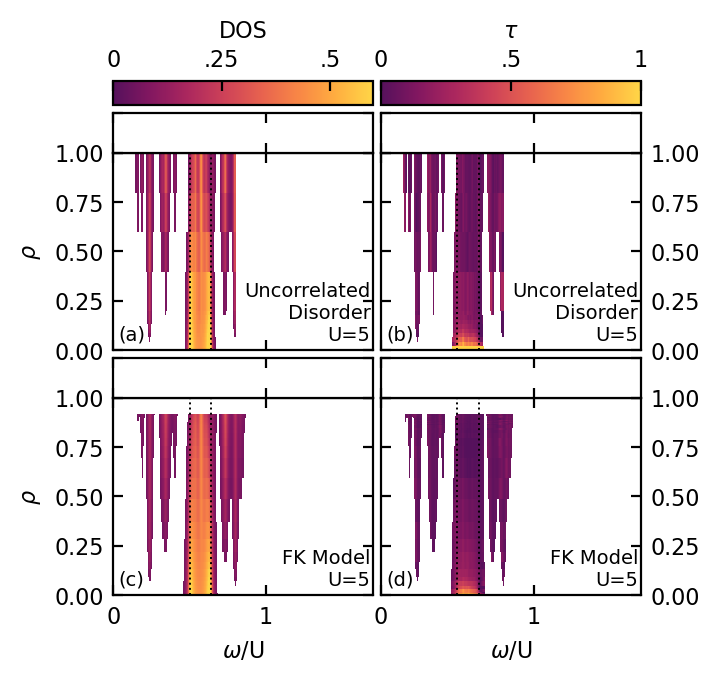

# with 1000 samples
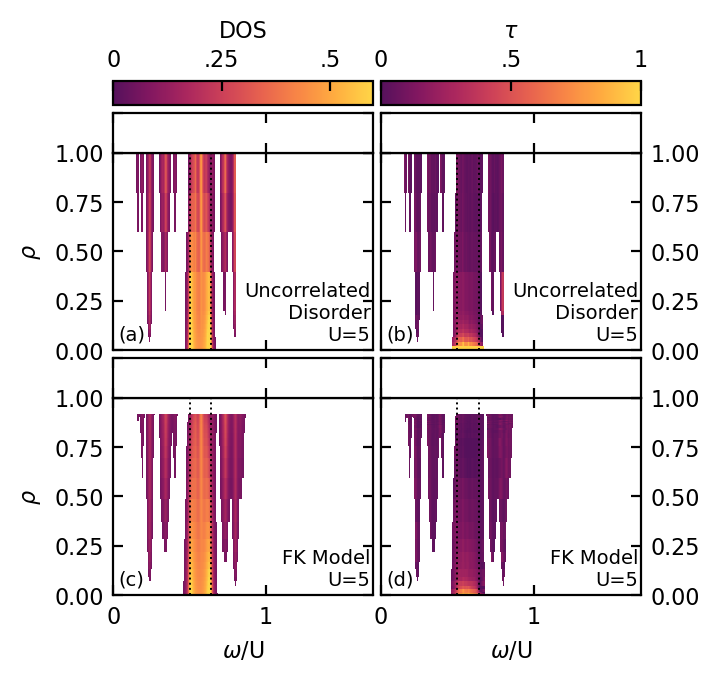

## Here's U=2 with 1000 samples

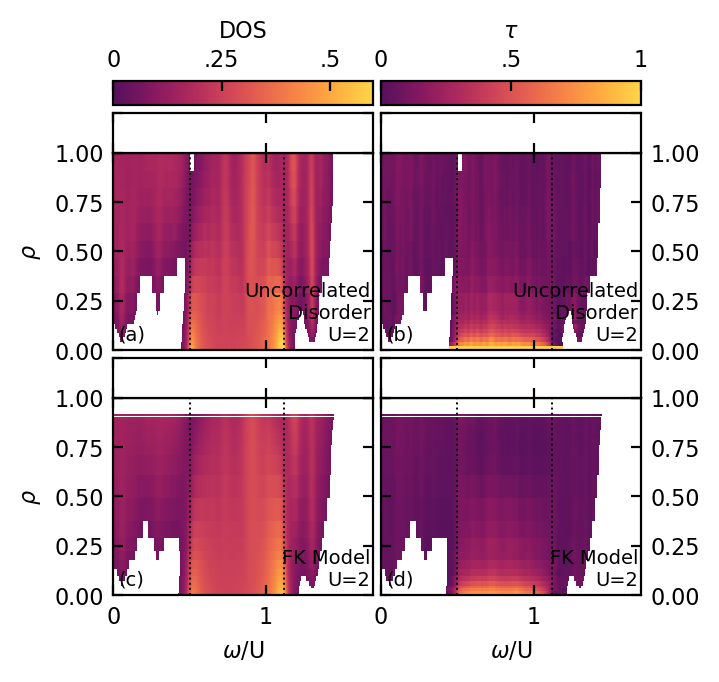